# Monte Carlo Simulations

The noise which is present in quantum mechanical systems can be theoretically
described by including random variables into Schroedinger's equation turning it
into a stochastic differential equation.

In the previous example of rabi driving, realistic experiments show some
instability in the resonance frequency. Resulting in slight shifts. Lets
therefore assume that the resonance frequency of our system is time dependent
as has a mean value of $\omega_0$.

\begin{equation}
\omega(t) = \omega_0 + \delta_\omega (t)
\end{equation}

Then we consider the following Hamilton operator in the rotating wave
approximation:

\begin{equation}
H = \hbar \delta_\omega (t) \sigma_z / 2 + \hbar A_x (t) \sigma_x / 2
+ \hbar A_y(t) \sigma_y / 2
\end{equation}

We can assume that the noise spectral density $S(f)$ of our random variable
$\delta_\omega$.

In Monte Carlo experiments, the equation is solved for a number of noise
realizations which are created from the spectral noise density $S$.
In the simulation we distinguish between the general case of a real valued
spectral noise density and quasi static noise. The latter describes noise
with has its spectral weight at frequencies which are slower than the quantum
gate, i.e. $S(f) = 0 \; \forall f > 1/T$ where $T$ is the total gate time.

The noise realizations required for the Monte Carlo simulations are created
in the NoiseTraceGenerator class. Lets consider the case of quasi static noise
first:

In [1]:
from qsim.noise import NTGQuasiStatic

ntg_quasi_static = NTGQuasiStatic(
    n_samples_per_trace=10,
    standard_deviation=[.5],
    n_traces=5,
    always_redraw_samples=False,
    sampling_mode='uncorrelated_deterministic'
)

The NTGQuasiStatic receives a standard deviation for each random variable. For
quasi static noise it is usually sufficient to sample only a few traces, while
many more are required to suppress the statistical uncertainties for general
noise spectral densities.

In the sampling mode uncorrelated_deterministic the noise is sampled
deterministically from a Gauss distribution and each variable is sampled
separately. Hence, the number of noise traces which are returned are
n_traces times the number of random variables.

The other implemented sampling mode is monte_carlo, where the noise traces are
created with help of random number generators and all random variables are
sampled at once.

Lets optimize the pulse now for quasi static noise. We begin with the same
setup as in the noiseless case:

In [2]:
import numpy as np

from qsim.matrix import DenseOperator
from qsim.solver_algorithms import SchroedingerSolver
from qsim.cost_functions import OperationInfidelity


sigma_x = DenseOperator(np.asarray([[0, 1], [1, 0]]))
sigma_y = DenseOperator(np.asarray([[0, -1j], [1j, 0]]))
sigma_z = DenseOperator(np.asarray([[1, 0], [0, -1]]))
zero_matrix = DenseOperator(np.asarray([[0, 0], [0, 0]]))

delta_omega = 0

h_ctrl = [.5 * sigma_x, .5 * sigma_y]
h_drift = [delta_omega * .5 * sigma_z]

n_time_steps = 10
total_time = 1

time_steps = (total_time / n_time_steps) * np.ones((n_time_steps, ))

control_amplitudes = np.zeros((n_time_steps, len(h_ctrl)))
control_amplitudes[:, 0] = np.pi

solver = SchroedingerSolver(
    h_drift=h_drift * n_time_steps,
    h_ctrl=h_ctrl,
    tau=time_steps
)
solver.set_optimization_parameters(0 * control_amplitudes)
x_half = sigma_x.exp(np.pi * .25j)

entanglement_infidelity = OperationInfidelity(
    solver=solver,
    target=x_half
)

Then we need to add a solver for the stochastic Schroedinger equation.

In [3]:
from qsim.solver_algorithms import SchroedingerSMonteCarlo

solver_qs_noise = SchroedingerSMonteCarlo(
    h_drift=h_drift * n_time_steps,
    h_ctrl=h_ctrl,
    h_noise=[sigma_z],
    initial_state=DenseOperator(np.eye(2)),
    noise_trace_generator=ntg_quasi_static,
    tau=time_steps
)

And a corresponding cost function which averages the entanglement infidelity
$F_e$ over the noise realizations to calculate the infidelity caused by noise
$_{n}F_e$:

\begin{equation}
_nF_e = \frac{1}{n_\text{traces}}\sum_{\delta_\omega} F
\end{equation}

In [4]:
from qsim.cost_functions import OperationNoiseInfidelity

qs_noise_cost = OperationNoiseInfidelity(
    solver=solver_qs_noise,
    target=sigma_x,
    neglect_systematic_errors=True
)

We need to add the new solver and cost function to the simulator. We then also
increase the maximal wall time since the Monte Carlo simulation is numerically
more complex.

In [5]:
from qsim.simulator import Simulator
from qsim.optimize import LeastSquaresOptimizer
simulator = Simulator(
    solvers=[solver, solver_qs_noise],
    cost_fktns=[entanglement_infidelity, qs_noise_cost]
)

termination_conditions = {
    "min_gradient_norm": 1e-15,
    "min_cost_gain": 1e-15,
    "max_wall_time": 120.0,
    "max_cost_func_calls": 1e6,
    "max_iterations": 1000,
    "min_amplitude_change": 1e-8
}

upper_bounds = 5 * 2 * np.pi * np.ones((len(h_ctrl) * n_time_steps, ))
lower_bounds = -1 * upper_bounds

optimizer = LeastSquaresOptimizer(
    system_simulator=simulator,
    termination_cond=termination_conditions,
    save_intermediary_steps=True,
    bounds=[lower_bounds, upper_bounds]
)

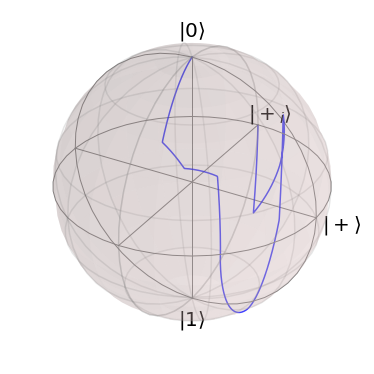

In [6]:
np.random.seed(0)
initial_pulse = np.pi * np.random.rand(n_time_steps, len(h_ctrl))

result = optimizer.run_optimization(initial_control_amplitudes=initial_pulse)
solver.set_optimization_parameters(result.final_parameters)
solver.plot_bloch_sphere()

The optimized pulses, which are not susceptible to quasi static noise

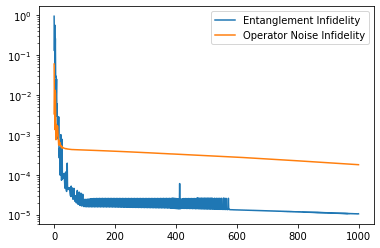

In [7]:
from qsim.data_container import DataContainer
from qsim.analyser import Analyser

data_container = DataContainer(
    storage_path=r'..\..\..\temp',
    file_name="File Name"
)

data_container.append_optim_result(optim_result=result)
analyser = Analyser(data=data_container)
analyser.plot_costs()

To discuss the general case of arbitrary noise spectra, lets consider the
example of Johnson noise, which directly applies to the control parameters.

The frequency range of the noise, we can sample is limited by the points in
time for which we compute noise samples. The lower limit is $f_{min} = 1/T$ where
$T$ is the total time of the pulse and the upper limit is given by
$f_{max} = 1 / \delta t$, where $\delta t$ is the spacing of the time steps. To
extend $f_{max}$ to higher values, we can use a simple transfer function, which
does nothing but oversampling the pulse.

In [8]:
from qsim.noise import NTGColoredNoise
from qsim.transfer_function import IdentityTF
oversampling = 100
def noise_spectral_density(f):
    return 1 / f

ntg_1_over_f = NTGColoredNoise(
    noise_spectral_density=noise_spectral_density,
    dt=time_steps[0] / oversampling,
    n_samples_per_trace=n_time_steps * oversampling,
    n_traces=100,
    n_noise_operators=2
)

identity_tf = IdentityTF(
    oversampling=oversampling,
    num_ctrls=2
)
identity_tf.set_times(time_steps)

As we apply the noise directly to the optimization parameters we can use the
class SchroedingerSMControlNoise, which also automatically takes the amplitude
function into account, if any is given.

In [11]:
from qsim.solver_algorithms import SchroedingerSMCControlNoise

solver_1_over_f = SchroedingerSMCControlNoise(
    h_drift=h_drift * n_time_steps * oversampling,
    h_ctrl=h_ctrl,
    initial_state=DenseOperator(np.eye(2)),
    noise_trace_generator=ntg_1_over_f,
    tau=total_time / n_time_steps / oversampling * np.ones(
        (n_time_steps * oversampling, )
    ),
    transfer_function=identity_tf
)

cost_1_over_f = OperationNoiseInfidelity(
    solver=solver_1_over_f,
    target=sigma_x,
    neglect_systematic_errors=True
)

solver_1_over_f.set_optimization_parameters(result.final_parameters)
cost_1_over_f.costs()

0.09697704449530707